In [1]:
import os
import math
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Dropout, Rescaling
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
from sklearn.metrics import accuracy_score

print(f"TensorFlow Version: {tf.__version__}")

# --- 1. DATA LOADING (SPARSE / INTEGER MODE) ---
# This mode is safer and fixes the Shape Mismatch error
TARGET_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
BATCHSIZE = 32

# Load Training Data (Int Mode)
train_raw = image_dataset_from_directory(
    './train_224/',
    image_size=TARGET_SIZE,
    batch_size=BATCHSIZE,
    label_mode='int',  # <--- Changed to 'int' to match your error shape (None, 1)
    shuffle=True,
    seed=123
)

# Load Validation Data (Int Mode)
val_raw = image_dataset_from_directory(
    './test_224/',
    image_size=TARGET_SIZE,
    batch_size=BATCHSIZE,
    label_mode='int',  # <--- Changed to 'int'
    shuffle=False
)

class_names = train_raw.class_names
NUM_CLASSES = len(class_names)
print(f"Classes: {class_names} (Total: {NUM_CLASSES})")

# Normalization
normalization_layer = Rescaling(1./255)
train_ds = train_raw.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_raw.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

2025-12-26 14:47:37.896832: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-26 14:47:37.897091: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-26 14:47:37.930947: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-26 14:47:38.747315: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

TensorFlow Version: 2.20.0
Found 287 files belonging to 5 classes.
Found 75 files belonging to 4 classes.
Classes: ['0', '1', '2', '3', '4'] (Total: 5)


/home/mohammad/.local/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-12-26 14:47:39.416729: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:

# --- 2. CALLBACKS ---
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_accuracy'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('accuracy'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_accuracy'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        if loss_type == 'epoch':
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.show()

history_this = LossHistory()

Training VGG16...
Loading weights from ./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
Starting training for 15 epochs...
Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6861 - loss: 0.9821
Epoch 1: val_accuracy improved from None to 0.96000, saving model to ./VGG16.h5



Epoch 1: finished saving model to ./VGG16.h5
9/9 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - accuracy: 0.7979 - loss: 0.7462 - val_accuracy: 0.9600 - val_loss: 0.0726
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8917 - loss: 0.2307
Epoch 2: val_accuracy improved from 0.96000 to 1.00000, saving model to ./VGG16.h5



Epoch 2: finished saving model to ./VGG16.h5
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.9164 - loss: 0.2032 - val_accuracy: 1.0000 - val_loss: 0.0259
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9759 - loss: 0.0807
Epoch 3: val_accuracy did not improve from 1.00000
9/9 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.9652 - loss: 0.0958 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9711 - loss: 0.1199
Epoch 4: val_accuracy did not improve from 1.00000
9/9 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.9721 - loss: 0.0770 - val_accuracy: 0.9867 - val_loss: 0.0296
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9646 - loss: 0.1031
Epoch 5: val_accuracy did not improve from 1.00000
9/9 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - accuracy: 0.9652 - loss: 0.1047 - val_accuracy: 1.0000 - val_loss: 1.0586e-04
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
Plotting results...

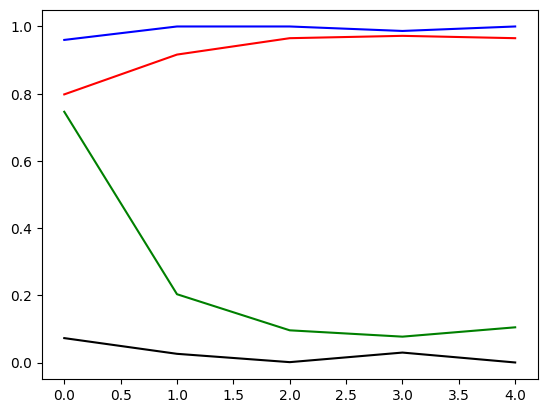

<Figure size 640x480 with 0 Axes>

In [3]:
# --- Updated VGG16 Function to Show Progress ---

def vgg16(num_class, epochs=20, frozen=15, lr=0.001, patience=2, dropout_rate=0.5, verbose=1, savepath='./VGG16.h5', history=history_this, input_shape=INPUT_SHAPE):
    # Check for weights file (force download if needed or use local)
    weights_path = './vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    if os.path.exists(weights_path):
        print(f"Loading weights from {weights_path}")
        base_model = VGG16(include_top=False, weights=weights_path, input_shape=input_shape)
    else:
        print("Local weights not found, downloading from ImageNet...")
        base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze layers
    for layer in base_model.layers[:frozen]:
        layer.trainable = False
    for layer in base_model.layers[frozen:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(num_class, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions, name='vgg16')

    # Use legacy Adam optimizer for M1/M2 Macs if needed, otherwise standard
    opt = Adam(learning_rate=lr)

    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Callbacks
    earlyStopping = callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=patience,
        verbose=1,
        mode='max',
        restore_best_weights=True # Important: keeps the best model, not the last one
    )

    saveBestModel = callbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )

    print(f"Starting training for {epochs} epochs...")

    # Train
    hist = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=[earlyStopping, saveBestModel, history],
        verbose=1  # verbose=1 shows the progress bar [======]
    )
    return hist

# --- Execution Cell ---

# Run the training
# We use fewer epochs (5) just to test if the progress bar appears
print("Training VGG16...")
vgg16(num_class=NUM_CLASSES, frozen=15, epochs=15, patience=3, lr=0.001, dropout_rate=0.5, verbose=1)

# Plot the results
print("Plotting results...")
history_this.loss_plot('epoch')
history_this.loss_plot('batch')

In [4]:

# --- 4. PREDICTION ---
def prediction(model_path):
    model = load_model(model_path)
    rootdir = './test_224/'
    test_labels = []
    test_images = []

    # Walk directories
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file.lower().endswith((".jpeg", ".jpg", ".png")):
                label_name = subdir.split('/')[-1]
                test_labels.append(label_name)
                test_images.append(os.path.join(subdir, file))

    predict_results = []
    class_indices = {name: i for i, name in enumerate(class_names)}
    index_to_label = {v: k for k, v in class_indices.items()}

    print(f"Predicting {len(test_images)} images...")

    for img_path in test_images:
        try:
            img = Image.open(img_path)
            img = img.resize(TARGET_SIZE)
            img_array = np.array(img) / 255.0  # Normalize
            img_array = np.expand_dims(img_array, axis=0)

            # Predict
            pred_probs = model.predict(img_array, verbose=0)
            pred_class_id = np.argmax(pred_probs, axis=1)[0] # Returns integer index

            predict_results.append(index_to_label[pred_class_id])
        except Exception as e:
            print(f"Error on {img_path}: {e}")
            predict_results.append("error")

    return accuracy_score(test_labels, predict_results)

In [5]:

# --- 5. HYPEROPT ---
def objective(params):
    print(f"Testing: {params}")
    try:
        vgg16(num_class=NUM_CLASSES,
              frozen=int(params['frozen']),
              epochs=int(params['epochs']),
              patience=int(params['patience']),
              lr=params['lr'],
              dropout_rate=params['dropout_rate'],
              verbose=0)

        acc = prediction('./VGG16.h5')
        print(f'Accuracy: {acc}')
        return {'loss': -acc, 'status': STATUS_OK}
    except Exception as e:
        print(f"Trial failed: {e}")
        return {'loss': 0, 'status': STATUS_OK} # Fail gracefully

space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'epochs': hp.quniform('epochs', 5, 8, 1),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.01)),
    'dropout_rate': hp.uniform('dropout_rate', 0.3, 0.6),
}

In [6]:

# Run
t1 = time.time()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=2)
print(f"Best: {best}")

Testing: {'dropout_rate': 0.4030958148904888, 'epochs': 7.0, 'frozen': 16.0, 'lr': 0.0003590163365412256, 'patience': 4.0}
Loading weights from ./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
Starting training for 7 epochs...                    
Epoch 1/7                                            

1/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.7188 - loss: 1.1193
2/9 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.7578 - loss: 0.9997
3/9 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.7691 - loss: 0.9399
4/9 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7799 - loss: 0.8809
5/9 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.7865 - loss: 0.8484
6/9 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.7951 - loss: 0.8108
7/9 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.8046 - loss: 0.7739 
8/9 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8115 - loss: 0.7451
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8181 - loss: 0.7178
                                                     
Epoc

                                                     
Epoch 1: finished saving model to ./VGG16.h5

9/9 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.8711 - loss: 0.4996 - val_accuracy: 1.0000 - val_loss: 0.0369

Epoch 2/7                                            

1/9 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9375 - loss: 0.1605
2/9 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.9453 - loss: 0.1494
3/9 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.9497 - loss: 0.1470
4/9 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9544 - loss: 0.1396
5/9 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9548 - loss: 0.1367
6/9 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.9563 - loss: 0.1319
7/9 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.9580 - loss: 0.1264 
8/9 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9584 - loss: 0.1234
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9591 - loss: 0.1201
                                                     
Epoch 2: val_accuracy did not improve fr

Predicting 75 images...                              
Accuracy: 1.0                                        
Testing: {'dropout_rate': 0.4914142086751401, 'epochs': 5.0, 'frozen': 16.0, 'lr': 0.003155916324851319, 'patience': 2.0}
Loading weights from ./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
Starting training for 5 epochs...                                 
Epoch 1/5                                                         

1/9 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.4375 - loss: 1.3901
2/9 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.5469 - loss: 2.0058
3/9 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.5208 - loss: 3.4643
4/9 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5332 - loss: 3.8479
5/9 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.5503 - loss: 3.9452
6/9 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.5688 - loss: 3.9000
7/9 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.5864 - loss: 3.8131 
8/9 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6005 - loss: 3.

                                                                  
Epoch 1: finished saving model to ./VGG16.h5

9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.7108 - loss: 2.7852 - val_accuracy: 0.9600 - val_loss: 0.1455

Epoch 2/5                                                         

1/9 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.8125 - loss: 0.6315
2/9 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.8281 - loss: 0.5885
3/9 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.8333 - loss: 0.5558
4/9 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.8418 - loss: 0.5211
5/9 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.8447 - loss: 0.5108
6/9 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.8506 - loss: 0.4926
7/9 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.8566 - loss: 0.4746 
8/9 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8594 - loss: 0.4634
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8619 - loss: 0.4521
                                                                  
E

                                                                  
Epoch 2: finished saving model to ./VGG16.h5

9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.8815 - loss: 0.3618 - val_accuracy: 0.9867 - val_loss: 0.0601

Epoch 3/5                                                         

1/9 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.9062 - loss: 0.2227
2/9 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.8984 - loss: 0.2364
3/9 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.8906 - loss: 0.2422
4/9 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.8887 - loss: 0.2377
5/9 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.8847 - loss: 0.2430
6/9 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.8857 - loss: 0.2392
7/9 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.8873 - loss: 0.2341 
8/9 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8868 - loss: 0.2327
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8866 - loss: 0.2307
                                                                  
E

                                                                  
Epoch 4: finished saving model to ./VGG16.h5

9/9 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.9199 - loss: 0.1890 - val_accuracy: 1.0000 - val_loss: 0.0588

Epoch 5/5                                                         

1/9 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 1.0000 - loss: 0.1883
2/9 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.9922 - loss: 0.1905
3/9 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.9774 - loss: 0.1951
4/9 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9714 - loss: 0.1927
5/9 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9633 - loss: 0.1947
6/9 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.9599 - loss: 0.1904
7/9 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.9573 - loss: 0.1858 
8/9 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9544 - loss: 0.1841
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9521 - loss: 0.1820
                                                                  
E

Predicting 75 images...                                           
Accuracy: 1.0                                                     
100%|██████████| 2/2 [08:34<00:00, 257.41s/trial, best loss: -1.0]
Best: {'dropout_rate': np.float64(0.4030958148904888), 'epochs': np.float64(7.0), 'frozen': np.float64(16.0), 'lr': np.float64(0.0003590163365412256), 'patience': np.float64(4.0)}
